In [335]:
import matplotlib.pyplot as plt
import numpy as np

import numba as nb
from multiprocessing import Process

from IPython import display

import cv2


In [189]:
def length(vector):
    """compute vector length"""
    return np.linalg.norm(vector)

def ClosestInterestion(spheres_scene, O, D, t_min, t_max):
    closest_t = float('inf')
    closest_sphere = None
    for sphere in spheres_scene.spheres:
        t1, t2 = spheres_scene.IntersectRaySphere(sphere, O, D)
        if t1 < t_max and t1 < closest_t and t1 > t_min:
            closest_t = t1
            closest_sphere = sphere
        if t2 < t_max and t2 < closest_t and t2 > t_min:
            closest_t = t2
            closest_sphere = sphere
    return closest_sphere, closest_t
    
def ReflectRay(R, N):
    return 2 * N * np.dot(N, R) - R

def RefrectRay(R, N, refrection_rate):
    rr = 1 / refrection_rate
    NR = N * R
    return rr * (N * (-N * R)) - N * np.sqrt(1 - rr**2 * np.dot(NR, NR))




In [182]:
class Light:
    """light class"""
    
    def __init__(self, light_type, intensity, position=None, direction=None):
        self.type = light_type # 'ambient', 'point', 'directional'
        self.intensity = np.array(intensity)
        self.position = np.array(position)     # when light type is 'point'
        self.direction = np.array(direction)   # when light type is 'directional'

class Lighting:
    """lighting system class"""
    
    def __init__(self):
        self.lights = []
        
    def AddLight(self, light_type, intensity, position=None, direction=None):
        light = Light(light_type, intensity, position, direction)
        self.lights.append(light)
        
    def ComputeLighting(self, spheres_scenes, P, N, V, s):
        """
        P: point on sphere
        N: normal at P
        V: viewing direction
        s: specular rate
        """
        
        intensity = np.array([0.0,0.0,0.0])
        for light in self.lights:
            if light.type == 'ambient':
                intensity += light.intensity
            else:
                if light.type == 'point':
                    L = light.position - P
                else:
                    L = light.direction
        
                # Shadow check
                shadow_sphere, shadow_t = ClosestInterestion(spheres_scenes, P, L, 1e-5, 1000)
                if shadow_sphere is not None:
                    continue
        
                # Diffuse
                N_dot_L = np.dot(N, L)
                if N_dot_L > 0:
                    intensity += light.intensity * N_dot_L / (length(N) * length(L))

                # Specular
                if s != 0:
                    R = 2 * N * np.dot(N, L) - L
                    R_dot_V = np.dot(R, V)
                    if R_dot_V > 0:
                        # cos(a)^s, the larger the s, the sinney it appears
                        intensity += light.intensity * ((R_dot_V / (length(R) * length(V)))**s)
                    
        return intensity
        

In [311]:
class Sphere:
    """3D sphere class"""
    
    def __init__(self, center=(0.0,0.0,0.0), radius=1.0, color=(0.0,0.0,0.0), 
                 specular=0, reflective=0, transparancy=0, refraction=1.0):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color, np.float32)
        self.specular = specular # 0 for matte
        self.reflective = reflective # 0 for not reflective
        self.transparancy = transparancy # 0 for not transparant
        self.refraction = refraction # 1.0 is in the vacuum

class SpheresScene:
    """
    a simple scene with only 3D spheres
    """
    
    def __init__(self):
        self.spheres = [] # a list of spheres
        
    def AddSphere(self, center=(0.0,0.0,0.0), radius=1.0, color=(0.0,0.0,0.0), 
                  specular=0, reflective=0,  transparancy=0, refraction=1.0):
        """add a sphere to the scene"""
        sphere = Sphere(center, radius, color, specular, reflective, 
                        transparancy, refraction)
        self.spheres.append(sphere)
        
    def IntersectRaySphere(self, sphere, O, D):
        """
        assume P is the point on the sphere
        < , > is the dot production
        -----------------------------------
        1) <P - C, P - C> = r^2 # sphere function
        2) P = O + tD           # assume P is on the ray
        
        plug 2) to 1):
        <O + tD - C, O + tD - C> = r^2
        
        because CO = O - C, rewrite the above equation as:
                          <CO + tD, CO + tD> = r^2
        =>   <CO, CO> + 2<CO, tD> + <tD, tD> = r^2
        =>   <CO, CO> + 2t<CO, D> + tt<D, D> = r^2
        
        now, we can solve for t
        """
        
        r = sphere.radius
        O = np.array(O) # origin of the ray
        D = np.array(D) # direction of the ray
        C = sphere.center # center of the sphere
        CO = O - C
        
        a = np.dot(D, D)
        b = 2*np.dot(CO, D)
        c = np.dot(CO, CO) - r**2
        
        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            return float('inf'), float('inf') # no solution
        
        t1 = (-b + np.sqrt(discriminant)) / (2*a)
        t2 = (-b - np.sqrt(discriminant)) / (2*a)

        return t1, t2
        
    def TraceRay(self, O, D, t_min, t_max, lighting, recursion_depth=3, in_ray=True):
        """
        O: the origin of the ray
        D: the direction (a unit vector) of the ray
        t_min and t_max define the ray tracing range
        --------------
        P = O + t * D
        """
        closest_sphere, closest_t = ClosestInterestion(self, O, D, t_min, t_max)
        
        if closest_sphere is None:
            return np.array((0.0,0.0,0.0)) # black color
        
        transparancy = closest_sphere.transparancy            
        
        # add lighting
        P = O + closest_t * D # compute intersection point
        N = P - closest_sphere.center # compute sphere normal at intersection point
        N = N / length(N) # unit normal vector
        
        # compute local color
        local_color = closest_sphere.color * lighting.ComputeLighting(self, P, N, -D, closest_sphere.specular)
        local_color = local_color * (1 - transparancy)
        
        # compute reflection
        r = closest_sphere.reflective
        if recursion_depth <= 0 or r <= 0:
            # if we hit the recursion limit or the object is not reflective, we are done
            #return local_color
            pass
        else:            
            # compute the reflected color
            R = ReflectRay(-D, N)
            reflect_color = self.TraceRay(P, R, 0.001, 1000, lighting, recursion_depth - 1)
            #return local_color * (1 - r) + reflect_color * r # weighted average
            local_color = local_color * (1 - r) + reflect_color * r # weighted average
        
        # compute refraction        
        if recursion_depth <= 0 or transparancy <= 0:
            # if we hit the recursion limit or the object is not reflective, we are done
            pass
        else:        
            refraction_rate = closest_sphere.refraction
            R = RefrectRay(-D, N, refraction_rate)
            refract_color = self.TraceRay(P, R, 0.001, 1e8, lighting, recursion_depth - 1, not in_ray)
            local_color = local_color + refract_color
            
            
            
        return local_color
    
            

In [340]:
class Camera:
    """camera class"""
    
    def __init__(self, center = (0.0,0.0,0.0), 
                 width = 256, height = 256,
                 p_width = 256, p_height = 256, d=1, t_max=1e8):
        self.center = center     # camera center
        self.width = width       # width of the canvas
        self.height = height     # height of the canvas
        self.p_width = p_width   # project plane width
        self.p_height = p_height # project plane height
        self.d = d  # d is the distance between the camera to the projection plane
        self.t_min = 0
        self.t_max = t_max # ray tracing maximum range
        self.center_x = self.width // 2
        self.center_y = self.height // 2
        self.buffer = np.zeros((self.height, self.width, 3), dtype=np.uint8) # 8-bit depth
        
        
    def Clear(self):
        """clear the display buffer"""
        self.buffer = np.zeros((self.height, self.width, 3), dtype=np.uint8)
    
    def PutPixel(self, x, y, color):
        """
        set the pixel color of (x,y)
        Note that: the center of canvas is the origin of coordinate system
        """
        # convert to the array coordinate system
        x_ = self.center_x + x
        y_ = self.center_y - y
        
        # convert floating-point color to integer if needed
        if type(color[0]) is float or type(color[0]) is np.float32 or type(color[0]) is np.float64:
            color = np.array(color).clip(0, 1.0)
            color = np.array(color * 255, dtype=np.uint8)
        else:
            color = np.array(color, dtype=np.uint8).clip(0, 255)
        
        # set the pixel color
        if x_ >= 0 and x_ < self.width and y_ >= 0 and y_ < self.height:
            self.buffer[y_, x_] = color

    def ArrayToCanvas(self, x_, y_):
        """convert column and row indices (x_, y_) to (x,y) on canvas"""
        x = x_ - self.center_x
        y = self.center_y - y_
        return x, y
            
    def CanvasToViewport(self, x, y):
        """
        determine which square on the viewport (the projection plane)
        corresponds to this pixel.
        in other words,
        for each pixel (x,y) on the canvas, we can determine its
        corresponding point on the viewport (Vx, Vy, d)
        """
        return np.array((x*self.p_width/self.width, 
                        y*self.p_height/self.height, 
                        self.d))

    def RayTracing(self, lighting, scene, show_progress=True, line_scan=True):
        """compute the color for each pixel by tracing the ray"""
        
        O = np.array(self.center)
        
        self.Clear() # clear the display buffer
        plt.figure(figsize=(10,10))    
        
        # scan all pixels on canvas
        if line_scan:
            # line scan
            for y_ in range(0, self.height):
                for x_ in range(0, self.width):
                    x, y = self.ArrayToCanvas(x_, y_)
                    D = self.CanvasToViewport(x, y)
                    color = scene.TraceRay(O, D, self.t_max, lighting)
                    self.PutPixel(x, y, color)
                if show_progress and y_ % (self.width // 50) == 0:
                    plt.clf()
                    display.clear_output(wait=True)
                    plt.imshow(self.buffer)
                    display.display(plt.gcf())
        else:
            # random scan
            scan_buffer = [(y_, x_) for y_ in range(0, self.height) for x_ in range(0, self.width)]
            scan_buffer = np.array(scan_buffer)
            scan_buffer = scan_buffer[np.random.permutation(len(scan_buffer))]
            for idx in range(len(scan_buffer)):
                y_ = scan_buffer[idx, 0]
                x_ = scan_buffer[idx, 1]
                x, y = self.ArrayToCanvas(x_, y_)
                D = self.CanvasToViewport(x, y)
                color = scene.TraceRay(O, D, 0, self.t_max, lighting)
                self.PutPixel(x, y, color)
                if show_progress and idx % 5000 == 0:
                    plt.clf()
                    display.clear_output(wait=True)
                    plt.imshow(self.buffer)
                    display.display(plt.gcf())

                    
        plt.clf()
        
        return self.buffer
    

## Render 3D Spheres with Ray Tracing

c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


<Figure size 720x720 with 0 Axes>

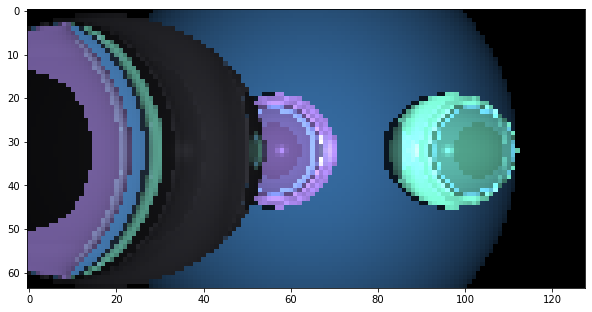

<Figure size 720x720 with 0 Axes>

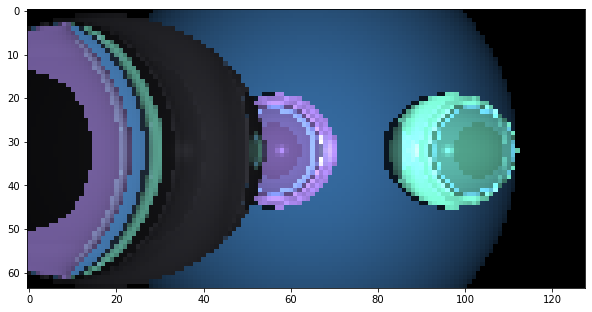

<Figure size 720x720 with 0 Axes>

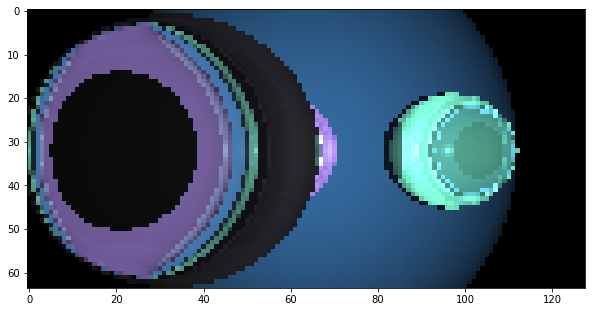

<Figure size 720x720 with 0 Axes>

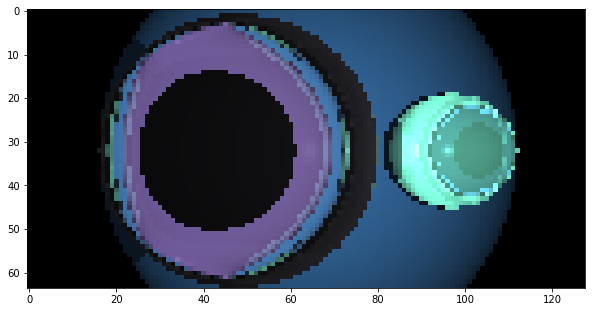

<Figure size 720x720 with 0 Axes>

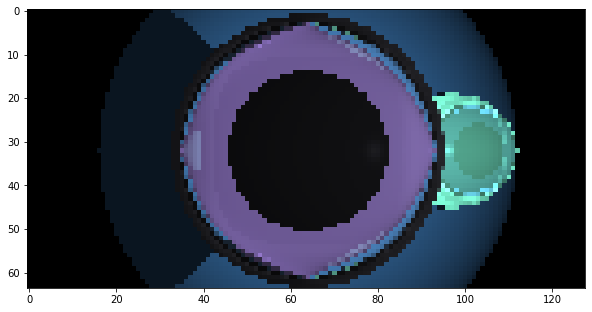

<Figure size 720x720 with 0 Axes>

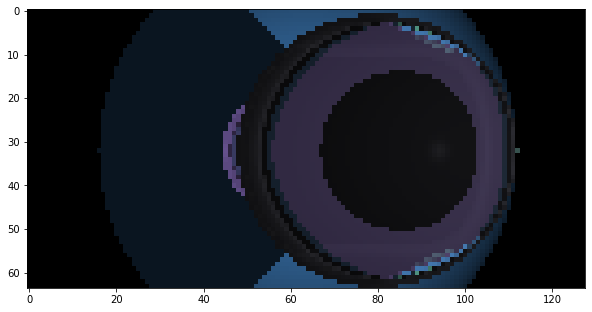

<Figure size 720x720 with 0 Axes>

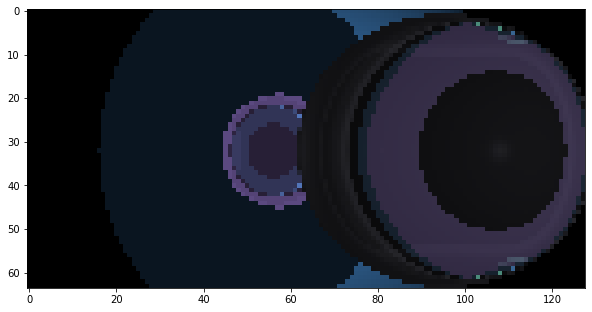

In [343]:
# create a camera
camera = Camera(center=(0.0,0.0,0.0), width=128, height=64, 
                p_width=2, p_height=1, d=1, t_max=1e8)

# add lights to the lighting system
lighting = Lighting()
lighting.AddLight('ambient', intensity = [0.2,0.2,0.2], position=None, direction=None)
lighting.AddLight('point', intensity = [0.8,0.8,0.8], position=(3,0,1), direction=None)
#lighting.AddLight('directional', intensity = [0.8,0.8,0.8], position=None, direction=(1,4,4))


# add some spheres to the scene
sphere_scene = SpheresScene()
refraction = 1.0
sphere_scene.AddSphere(center=(-3.0,0,5.0), radius=2.2, color=(0.8,0.8,0.9), specular=100, reflective=0.3, transparancy=0.9, refraction=1.3) 

sphere_scene.AddSphere(center=(-10,0,100), radius=20, color=(.5,.4,.7), specular=100, reflective=0.3, transparancy=0.1, refraction=1.3) 
sphere_scene.AddSphere(center=(50,0,100), radius=20, color=(.35,.7,.6), specular=100, reflective=0.3, transparancy=0.1, refraction=1.3) 

sphere_scene.AddSphere(center=(0,0,5000.0), radius=3000, color=(0.3,0.6,.9), specular=200, reflective=0.3, transparancy=0.0, refraction=1.0) 

img = camera.RayTracing(lighting, sphere_scene, show_progress=False, line_scan=False)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

#"""
for x in range(-3,3,1):
    sphere_scene.spheres[0].center = (x,0,5.0)
    img = camera.RayTracing(lighting, sphere_scene, show_progress=False, line_scan=False)
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
#"""

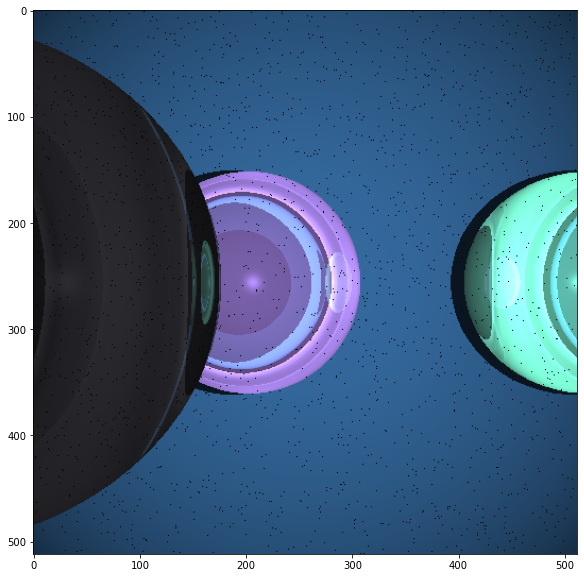

<Figure size 720x720 with 0 Axes>

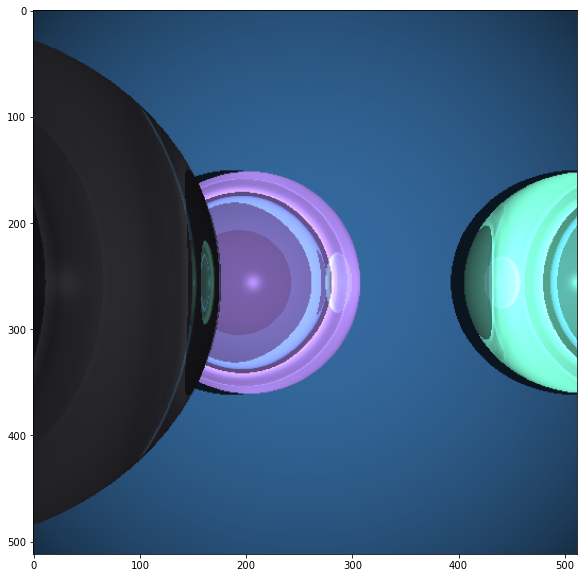

In [349]:
# create a camera
W = 512
H = 512
camera = Camera(center=(0.0,0.0,0.0), width=W, height=H, 
                p_width=W/H, p_height=1, d=1, t_max=1e8)


sphere_scene = SpheresScene()
refraction = 1.0
sphere_scene.AddSphere(center=(-3.0,0,5.0), radius=2.2, color=(0.8,0.8,0.9), specular=100, reflective=0.3, transparancy=0.9, refraction=1.3) 

sphere_scene.AddSphere(center=(-10,0,100), radius=20, color=(.5,.4,.7), specular=100, reflective=0.3, transparancy=0.1, refraction=1.3) 
sphere_scene.AddSphere(center=(50,0,100), radius=20, color=(.35,.7,.6), specular=100, reflective=0.3, transparancy=0.1, refraction=1.3) 

sphere_scene.AddSphere(center=(0,0,5000.0), radius=3000, color=(0.3,0.6,.9), specular=200, reflective=0.3, transparancy=0.0, refraction=1.0) 


img = camera.RayTracing(lighting, sphere_scene, show_progress=True, line_scan=False)



plt.figure(figsize=(10,10))
plt.imshow(img)

In [20]:
#import cv2

#img = cv2.cvtColor(camera.buffer, cv2.COLOR_BGR2RGB)
#cv2.imwrite('./4k.jpg', img)

True